### Imports

In [1]:
import sys
import numpy as np
import math
from IPython.display import display, Math, Latex, Markdown, HTML

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

## Point To Point

### Data Plotting

In [2]:
'''Plot the true and moved data using Matplotlib'''
def plotData(data1, data2, label1, label2, markersize1 = 20, markersize2 = 20):
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.set_title("Point Clouds")
    if data1 is not None:
        xdata1 = data1[0, :]
        ydata1 = data1[1, :]
        zdata1 = data1[2, :]
        ax.scatter3D(xdata1, ydata1, zdata1, s= markersize1, label = label1);
    
    if data2 is not None:
        xdata2 = data2[0, :]
        ydata2 = data2[1, :]
        zdata2 = data2[2, :]
        ax.scatter3D(xdata2, ydata2, zdata2, s= markersize2, label=label2);

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()

def plotValues(values, label):
    plt.figure(figsize = (10, 4))
    plt.title("Error")
    plt.plot(values, label=label)
    plt.legend()
    plt.grid(True)
    plt.show()

### Data Generation

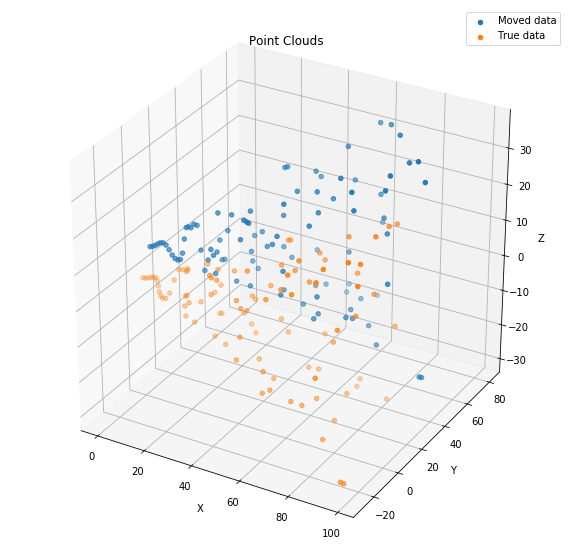

In [3]:
'''Generate data using the sin and cosine functions'''
def generateSpiral(numPoints, angle, shift):
    
    aboutZ = np.array([[math.cos(angle[2]), -math.sin(angle[2]), 0], 
                      [math.sin(angle[2]), math.cos(angle[2]), 0],
                      [0, 0, 1]])
    aboutY = np.array([[math.cos(angle[1]), 0, -math.sin(angle[1])],
                      [0, 1, 0] ,
                      [math.sin(angle[1]), 0, math.cos(angle[1])]])
    aboutX = np.array([[1, 0, 0],
                      [0, math.cos(angle[0]), -math.sin(angle[0])],
                      [0, math.sin(angle[0]), math.cos(angle[0])]])
      
    T = shift
    R = aboutZ.dot(aboutY.dot(aboutX))
    sourceData = np.zeros((3, numPoints))
    sourceData[0, :] = range(0, numPoints)
    sourceData[1, :] = 0.3 * sourceData[0, :] * np.sin(0.5 * sourceData[0, :]) 
    sourceData[2, :] = 0.3 * sourceData[0, :] * np.sin(0.5 * sourceData[1, :]) 
    
    movedData = R.dot(sourceData) + shift
    return sourceData, movedData

'''Assign data to point clouds P and Q''' 
angle = [0, 0, math.pi/5]
shift = np.array([[0], [6], [7]])
Q, P = generateSpiral(100, angle, shift)

plotData(P, Q, "Moved data", "True data")
plt.show()

### Identifying Corresponding Points 

In [4]:
'''For each point in the  moved data get closest points in the source data'''
def getCorrespondences(P, Q):
    pSize = P.shape[1]
    qSize = Q.shape[1]
    correspondences = []
    for i in range(pSize):
        pPoint = P[:, i]
        minDist = sys.maxsize
        chosenIndex = -1
        for j in range(qSize):
            qPoint = Q[:, j]
            dist = np.linalg.norm(qPoint - pPoint)
            if dist < minDist:
                minDist = dist
                chosenIndex = j
        correspondences.append((i, chosenIndex))
    return correspondences

'''Connect the obtained corresponding points using grey lines'''
def drawCorrespondences(P, Q, correspondences):
    labelAdded = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        z = [P[2, i], Q[2, j]]
        if not labelAdded:
            plt.plot(x, y, z, color = 'grey', label = 'Correpondences')
            labelAdded = True
        else:
            plt.plot(x, y, z, color = 'grey')
    plt.legend()

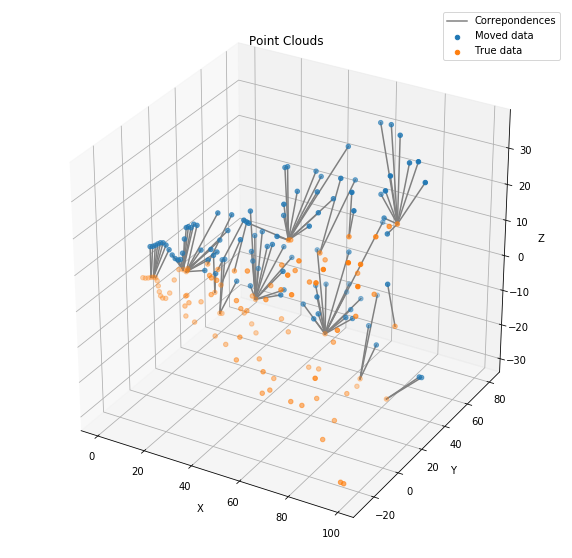

In [5]:
correspondences = getCorrespondences(P, Q)
plotData(P, Q, "Moved data", "True data")
drawCorrespondences(P, Q, correspondences)

In [6]:
def RotationMatrix(phi, theta, shi):
    return Matrix([
    [cos(shi) * cos(theta), cos(shi) * sin(theta) * sin(phi) - sin(shi) * cos(phi), cos(shi) * sin(theta) * cos(phi) + sin(shi) * sin(phi)], 
    [sin(shi) * cos(theta), sin(shi) * sin(theta) * sin(phi) + cos(shi) * cos(phi), sin(shi) * sin(theta) * cos(phi) - cos(shi) * sin(phi)],
    [-sin(theta), cos(theta) * sin(phi), cos(theta) * cos(phi)]])

def R(phi, theta, shi): 
    return np.array([
    [math.cos(shi) * math.cos(theta), math.cos(shi) * math.sin(theta) * math.sin(phi) - math.sin(shi) * math.cos(phi), math.cos(shi) * math.sin(theta) * math.cos(phi) + math.sin(shi) * math.sin(phi)], 
    [math.sin(shi) * math.cos(theta), math.sin(shi) * math.sin(theta) * math.sin(phi) + math.cos(shi) * math.cos(phi), math.sin(shi) * math.sin(theta) * math.cos(phi) - math.cos(shi) * math.sin(phi)],
    [-math.sin(theta), math.cos(theta) * math.sin(phi), math.cos(theta) * math.cos(phi)]])

In [7]:
from sympy import init_printing, symbols, Matrix, cos, sin, diff
from IPython.display import display, Math, Latex, Markdown, HTML
from sympy import lambdify
from tqdm import tqdm 

init_printing(use_unicode = True)


x, y, z, phi, theta, shi, p_x, p_y, p_z= symbols('x, y, z, \\phi, \\theta, \\psi, p_x, p_y, p_z')


t = Matrix([[x], [y], [z]])
X = Matrix([x, y, z, phi, theta, shi])
p = Matrix([[p_x], [p_y], [p_z]])

_moved_point = RotationMatrix(phi, theta, shi) * p + t

_jacobian = diff(_moved_point, X).reshape(6, 3).transpose() 

display(Latex('Moved Point'), _moved_point)
display(Latex('Jacobian'), _jacobian)

<IPython.core.display.Latex object>

⎡pₓ⋅cos(\psi)⋅cos(\theta) + p_y⋅(sin(\phi)⋅sin(\theta)⋅cos(\psi) - sin(\psi)⋅c
⎢                                                                             
⎢pₓ⋅sin(\psi)⋅cos(\theta) + p_y⋅(sin(\phi)⋅sin(\psi)⋅sin(\theta) + cos(\phi)⋅c
⎢                                                                             
⎣                                       -pₓ⋅sin(\theta) + p_y⋅sin(\phi)⋅cos(\t

os(\phi)) + p_z⋅(sin(\phi)⋅sin(\psi) + sin(\theta)⋅cos(\phi)⋅cos(\psi)) + x ⎤
                                                                            ⎥
os(\psi)) + p_z⋅(-sin(\phi)⋅cos(\psi) + sin(\psi)⋅sin(\theta)⋅cos(\phi)) + y⎥
                                                                            ⎥
heta) + p_z⋅cos(\phi)⋅cos(\theta) + z                                       ⎦

<IPython.core.display.Latex object>

⎡1  0  0  p_y⋅(sin(\phi)⋅sin(\psi) + sin(\theta)⋅cos(\phi)⋅cos(\psi)) + p_z⋅(-
⎢                                                                             
⎢0  1  0  p_y⋅(-sin(\phi)⋅cos(\psi) + sin(\psi)⋅sin(\theta)⋅cos(\phi)) + p_z⋅(
⎢                                                                             
⎣0  0  1                                     p_y⋅cos(\phi)⋅cos(\theta) - p_z⋅s

sin(\phi)⋅sin(\theta)⋅cos(\psi) + sin(\psi)⋅cos(\phi))   -pₓ⋅sin(\theta)⋅cos(\
                                                                              
-sin(\phi)⋅sin(\psi)⋅sin(\theta) - cos(\phi)⋅cos(\psi))  -pₓ⋅sin(\psi)⋅sin(\th
                                                                              
in(\phi)⋅cos(\theta)                                                    -pₓ⋅co

psi) + p_y⋅sin(\phi)⋅cos(\psi)⋅cos(\theta) + p_z⋅cos(\phi)⋅cos(\psi)⋅cos(\thet
                                                                              
eta) + p_y⋅sin(\phi)⋅sin(\psi)⋅cos(\theta) + p_z⋅s

In [8]:
s = (phi, theta, shi, p_x, p_y, p_z)
lambdaJacobian = lambdify(s, _jacobian, modules='numpy')

def calculateJacobian(x, p):
    J = lambdaJacobian(*x.reshape(-1)[3:], *list(p))
    return np.array(J)

In [9]:
s = (x, y, z, phi, theta, shi, p_x, p_y, p_z)
calcuatemovedpoint = lambdify(s, _moved_point, modules='numpy')

def calculateError(x, pPoint, qPoint):
    x = x.reshape(-1)
    pNew = calcuatemovedpoint(*x, *pPoint)
    return pNew - qPoint.reshape(3, 1)     

In [13]:
def prepareSystem(x, P, Q, correspondences, kernel = lambda distance: 1.0):
    H = np.zeros((6, 6))
    g = np.zeros((6, 1))
    chi = 0
    
    for i, j in correspondences:
        pPoint, qPoint = P[:, i], Q[:, j]
        e = calculateError(x, pPoint, qPoint)
        weight = kernel(e)
        
        J = calculate_jacobian(x, pPoint)
        H += weight * J.T.dot(J).reshape(6,6)
        g += weight * J.T.dot(e)
        
        chi += e.T * e
        
    return H, g, chi

In [11]:
def ICPleastsquares(P, Q, iterations=30, kernel = lambda distance: 1.0):
    x = np.zeros((6, 1))
    chiValues = []
    xValues = [x.copy()]  # Initial value for transformation.
    Pvalues = [P.copy()]
    Pcopy = P.copy()
    correspValues = []
    for it in tqdm( range(iterations), desc ="Iteration"):
        rot = R(*x[3:])
        t = x[0:3]
        correspondences = getCorrespondences(Pcopy, Q)
        correspValues.append(correspondences)
        H, g, chi = prepareSystem(x, P, Q, correspondences, kernel)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x += dx
        
        chiValues.append(chi.item(0))
        xValues.append(x.copy())
        rot = R(*x[3:])
        t = x[0:3]
        Pcopy = rot.dot(P.copy()) + t
        Pvalues.append(Pcopy)
    correspValues.append(correspValues[-1])
    return Pvalues, chiValues, correspValues

In [12]:
%%time
Pvalues, chiValues, correspValues = ICPleastsquares(P, Q)
plotValues(chiValues, label="Chi^2")
plotData(Pvalues[-1], Q, 'Moved Final', 'True Data', markersize1=115)

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]


NameError: name 'calculate_error' is not defined